In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from sklearn import linear_model
import matplotlib.pyplot as plt

## Lotka-Volterra synthetic example

#### Set up a function to simulate Lotka-Volterra dynamics

In [2]:
def lotkavolterra_hidden(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

In [3]:
t_range = [0, 15]
x0 = [10, 5]

#### Step forward in time

In [4]:
sol = solve_ivp(lotkavolterra_hidden, t_range, x0, args=(1.5, 1, 3, 1), dense_output=True)
t = np.linspace(0, 15, 300)
dt = t[1]-t[0]
z = sol.sol(t)

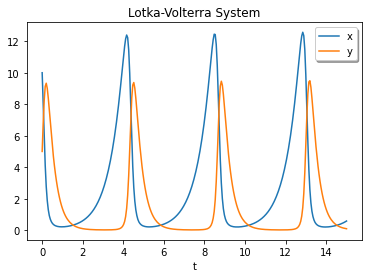

In [5]:
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()

#### z is our time series data for x1 and x2

In [6]:
x1 = z[0]
x2 = z[1]

#### Take derivative

In [7]:
n = len(t)

x1dots = []
x2dots = []

for j in range(1,n-1):
    x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
    x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
    
    x1dots.append(x1dot)
    x2dots.append(x2dot)

In [8]:
x1s = x1[1:-1]
x2s = x2[1:-1]

#### Build matrix A

In [9]:
A = [x1s, 
     x2s, 
     x1s*x2s,
     x1s**2,
     x2s**2,
     x1s**3,
     x2s**3,
     (x1s**2) * x2s,
     (x2s**2) * x1s]

In [10]:
A = np.array(A)
x1dots = np.array(x1dots)
x2dots = np.array(x2dots)

In [11]:
x = np.arange(len(A))

#### Run linear regression to get coefficients for dominant terms

<BarContainer object of 9 artists>

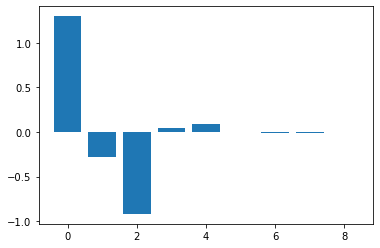

In [12]:
clf1 = linear_model.Lasso(alpha=0.001)

clf1.fit(A.T, x1dots)
plt.bar(x, clf1.coef_)

In [13]:
np.round(clf1.coef_, 2)

array([ 1.3 , -0.28, -0.92,  0.05,  0.09, -0.  , -0.01, -0.01,  0.  ])

/Users/knuth/miniconda3/envs/amath/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.480000104905902, tolerance: 2.2799407393978433
  model = cd_fast.enet_coordinate_descent(


<BarContainer object of 9 artists>

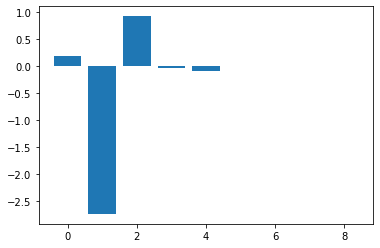

In [14]:
clf2 = linear_model.Lasso(alpha=0.001)

clf2.fit(A.T, x2dots)
plt.bar(x, clf2.coef_)

In [15]:
np.round(clf2.coef_, 2)

array([ 0.18, -2.73,  0.92, -0.04, -0.09,  0.  ,  0.01,  0.  ,  0.  ])

#### Pull out dominant terms and create derived function

In [16]:
a = clf1.coef_[0]
b = clf1.coef_[2]
c = clf2.coef_[1]
d = clf2.coef_[2]

def lotkavolterra_derived(t, z, a, b, c, d):
    x, y = z
    return [a*x + b*x*y, c*y + d*x*y]

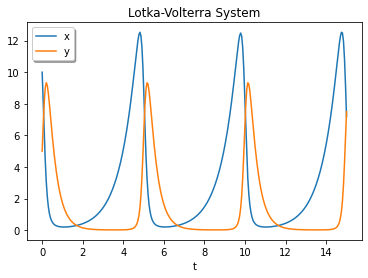

In [17]:
sol = solve_ivp(lotkavolterra_derived, t_range, x0, args=(a,b,c,d), dense_output=True)
t = np.linspace(0, 15, 300)
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()

#### Compare with original

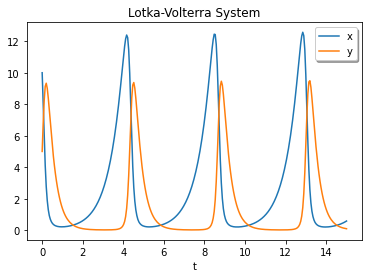

In [18]:
sol = solve_ivp(lotkavolterra_hidden, t_range, x0, args=(1.5, 1, 3, 1), dense_output=True)
t = np.linspace(0, 15, 300)
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()

The result is similar, but not exactly the same.  The timing of the peaks seems to be off. Not sure why... perhaps there is a mistake, or is this expected? The functions seem identical, except for the weight of the coefficients a,b,c,d...

# HW 02 Q1 Develop a DMD model to forecast the future population states

In [19]:
import pandas as pd

#### Build the data frame to match what is provided with the homework

In [20]:
table = '1845 20 32 1847 20 50 1849 52 12 1851 83 10 1853 64 13 1855 68 36 1857 83 15 1859 12 12 1861 36 6 1863 150 6 1865 110 65 1867 60 70 1869 7 40 1871 10 9 1873 70 20 1875 100 34 1877 92 45 1879 70 40 1881 10 15 1883 11 15 1885 137 60 1887 137 80 1889 18 26 1891 22 18 1893 52 37 1895 83 50 1897 18 35 1899 10 12 1901 9 12 1903 65 25'.split()

In [21]:
table = list(map(int, table))

years = table[::3]
hare = table[1::3]
lynx = table[2::3]

dict = {'year': years, 'hare': hare, 'lynx': lynx} 
df = pd.DataFrame(dict) 

df = df.set_index(['year'])
df

,hare,lynx
year,,
1845,20,32
1847,20,50
1849,52,12
1851,83,10
1853,64,13
1855,68,36
1857,83,15
1859,12,12
1861,36,6


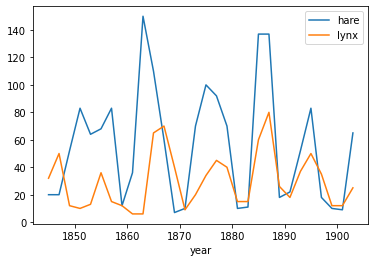

In [22]:
df.plot()

#### Pull out time series values

In [23]:
t = df.index.values
dt = t[1] - t[0]
x1 = df['hare'].values
x2 = df['lynx'].values

#### Take derivative

In [24]:
n = len(t)

x1dots = []
x2dots = []

for j in range(1,n-1):
    x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
    x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
    
    x1dots.append(x1dot)
    x2dots.append(x2dot)

In [25]:
x1s = x1[1:-1]
x2s = x2[1:-1]

#### Build matrix A

In [26]:
A = [x1s, 
     x2s, 
     x1s*x2s,
     x1s**2,
     x2s**2,
     x1s**3,
     x2s**3,
     (x1s**2) * x2s,
     (x2s**2) * x1s]

In [27]:
A = np.array(A)
x1dots = np.array(x1dots)
x2dots = np.array(x2dots)

#### Run linear regression to get coefficients for dominant terms

/Users/knuth/miniconda3/envs/amath/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2210.8659543184904, tolerance: 0.9642044642857142
  model = cd_fast.enet_coordinate_descent(


<BarContainer object of 9 artists>

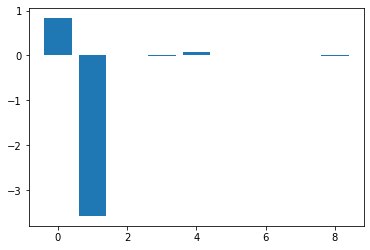

In [28]:
clf1 = linear_model.Lasso(alpha=1)
clf1.fit(A.T, x1dots)

x = np.arange(len(A))
plt.bar(x, clf1.coef_)

In [29]:
np.round(clf1.coef_, 2)

array([ 0.83, -3.57,  0.02, -0.02,  0.07,  0.  , -0.  ,  0.  , -0.  ])

/Users/knuth/miniconda3/envs/amath/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.8827701717111, tolerance: 0.20610424107142855
  model = cd_fast.enet_coordinate_descent(


<BarContainer object of 9 artists>

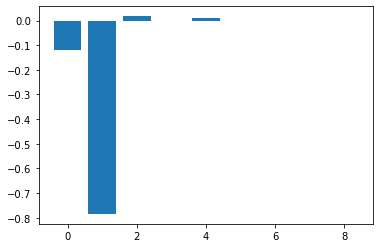

In [30]:
clf2 = linear_model.Lasso(alpha=1)

clf2.fit(A.T, x2dots)
plt.bar(x, clf2.coef_)

In [31]:
np.round(clf2.coef_, 2)

array([-0.12, -0.78,  0.02, -0.  ,  0.01,  0.  , -0.  , -0.  , -0.  ])

#### Pull out dominant terms and create derived function

In [32]:
a = clf1.coef_[0]
b = clf1.coef_[1]
c = clf2.coef_[0]
d = clf2.coef_[1]

In [33]:
def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x + b*y, c*x + d*y]

#### Compare with original

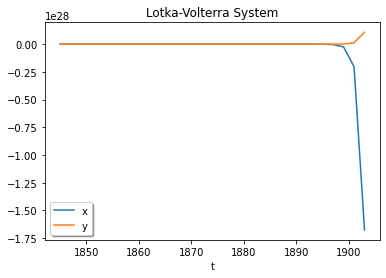

In [34]:
t_range = [t[0], t[-1]]
x0 = [x1[0], x2[0]]

sol = solve_ivp(lotkavolterra, t_range, x0, args=(a,b,c,d), dense_output=True)
t = df.index.values
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()

Hmmm... this doesn't look right at all. Not sure what the issue might be... perhaps a time stepping issue? Or is taking the derivative not sufficient to capture the dominant modes?

## Lecture example in Python (no questions below here...)

In [35]:
def rhs_dyn(t,x,mu):
    
    rhs = [x[1], mu*(1-x[0]**2)*x[1]-x[0]]
    
    return rhs

In [36]:
t_range = [0,50]
x0 = [0.1, 5]
mu = 1.2

In [37]:
sol = solve_ivp(rhs_dyn, t_range, x0, args=[mu], dense_output=True)

In [38]:
dt = 0.01
t  = np.arange(0,50,dt) 
z = sol.sol(t)

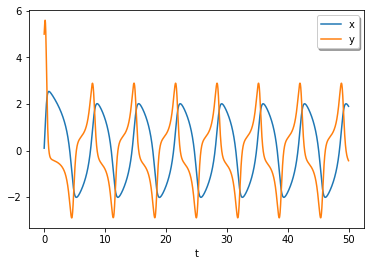

In [39]:
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.show()

In [40]:
x1 = z[0]
x2 = z[1]

In [41]:
n = len(t)

In [42]:
x1dots = []
x2dots = []

for j in range(1,n-1):
    x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
    x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
    
    x1dots.append(x1dot)
    x2dots.append(x2dot)

In [43]:
x1s = x1[1:-1]
x2s = x2[1:-1]

In [44]:
noise = np.random.normal(0, .2, x1s.shape)
x1s = x1[1:-1] + noise

noise = np.random.normal(0, .2, x2s.shape)
x2s = x2[1:-1] + noise

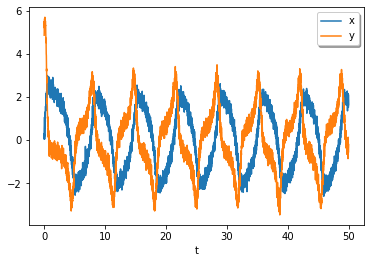

In [45]:
plt.plot(t[1:-1], x1s)
plt.plot(t[1:-1], x2s)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.show()

In [46]:
A = [x1s, 
     x2s, 
     x1s*x2s,
     x1s**2,
     x2s**2,
     x1s**3,
     x2s**3,
     (x1s**2) * x2s,
     (x2s**2) * x1s]

In [47]:
A = np.array(A)
x1dots = np.array(x1dots)
x2dots = np.array(x2dots)

In [48]:
x = np.arange(9)

<BarContainer object of 9 artists>

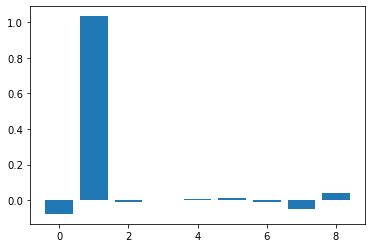

In [49]:
clf1 = linear_model.Lasso(alpha=0.001)

clf1.fit(A.T, x1dots)
plt.bar(x, clf1.coef_)

<BarContainer object of 9 artists>

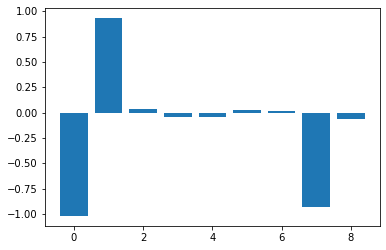

In [50]:
clf2 = linear_model.Lasso(alpha=0.001)

clf2.fit(A.T, x2dots)
plt.bar(x, clf2.coef_)

In [51]:
np.round(clf2.coef_, 2)

array([-1.02,  0.93,  0.04, -0.04, -0.05,  0.02,  0.02, -0.93, -0.06])

In [52]:
a = clf1.coef_[1]
b = clf2.coef_[0]
c = clf2.coef_[1]
d = clf2.coef_[7]

In [53]:
def rhs_dyn(t,x,mu):
    rhs = [x[1], mu*(1-x[0]**2)*x[1]-x[0]]
    return rhs

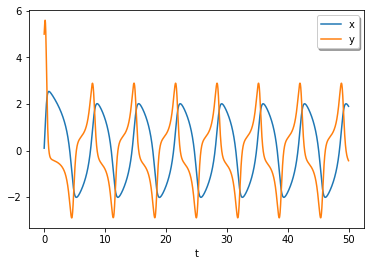

In [54]:
t_range = [0,50]
x0 = [0.1, 5]
mu = 1.2

sol = solve_ivp(rhs_dyn, t_range, x0, args=[mu], dense_output=True)

dt = 0.01
t  = np.arange(0,50,dt) 
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.show()

In [55]:
def rhs_dyn(t,z,a,b,c,d):
    x, y = z
    rhs = [a*y, b*x + c*y + d*(x**2)*y]
    return rhs

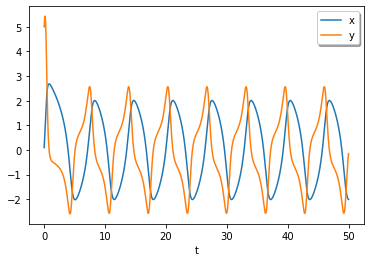

In [56]:
t_range = [0,50]
x0 = [0.1, 5]

sol = solve_ivp(rhs_dyn, t_range, x0, args=[a,b,c,d], dense_output=True)

dt = 0.01
t  = np.arange(0,50,dt) 
z = sol.sol(t)

plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.show()